# Exercise Sheet 3 - Covid-19 Classification using Transfer Learning

- Deep Learning for Computer Vision - Winter Term 2024/25
- Lecture by: Constantin Pape
- Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
- Due date: **Tuesday**, Dec 3, before 10:00

## Time Required to Solve this Exercise Sheet

As you will train deep CNNs on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.

## Topic

In this exercise, you will solve an image classification task from medical imaging: classification in Chest X-Ray images into patients with Covid-19, Pneunomia or Healthy. We will use a subset of the dataset from a Kaggle challenge for this. (https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia)

The main focus of this exercise is transfer learning and you will approach the classification task with three different approaches:

    Training ResNets from scratch. (Note that we will use the ResNet implementation from torchvision throughout the exercise).
    Training ResNets pretrained on ImageNet.
    Training ResNets pretrained on RadImageNet, a large radiology dataset.

In addition you can combine these approaches with other methods to improve the model at the end and upload your best solution on a hold-out test set. This is explained in more details at the end of the exercise.

### Hints

In the first part of the exercise you will train ResNets from scratch, analyze the effects of deeper models with small training data and use data augmentations. In the second part, you will solve the same task using pretrained ResNets (from ImageNet - pretrained on natural images; and RadImageNet - pretrained on the medical imaging domain).

To understand the background of this exercise, you can:
- Review the lectures
    - Lecture 3 on CNNs
    - Lecture 4 on Transfer Learning and Augmentaion
- Check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

At the end of the exercise you should further improve your model. You can draw upon a number of techniques we discussed for improving model performance. The predictions from your best model on a hold-out test set should be uploaded together with the exercise. More explanation is given at the end of the exercise sheet.

_Do not hesitate to ask questions and ideally discuss them with the fellow students on Matrix! We will monitor the channel to provide you help if your discussions get stuck._

## IMPORTANT SUBMISSION INSTRUCTIONS
- **You need to answer all the questions in written form**
- When you are done, download the notebook from Kaggle and **rename** it to `<surname1>_<surname2>_<surname3>.ipynb`
- For the final submission:
    - Submit the **Jupyter Notebook** (.ipynb file). Upload them on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Notebook` -> `Tutorial <X>` (where, `X` is the tutorial you are assigned to).
    - Submit the **Challenge Results** (.csv file) (for the unlabeled images, namely `unknown`). Upload them on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Challenge Results` -> `Tutorial <X>`
- Make only one submission of the exercise and results per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

Implementation
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs and answer the **questions** asked. In addition to the python packages loaded below, you are allowed to use any packages you want.

**Importing required libraries:**

We have provided the most essential libraries to be used for the exercise. Feel free to add modules as per your requirement.

In [12]:
import os
from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms

%pip install barbar

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Setting up the device (make sure device returns "cuda" to use of the GPUs on kaggle)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Getting the Required Functionalities

We first download and import `ex3_utils.py`, which in which functions for training evaluation etc. are already implemented (similar to the previous exercise). You can download this file and inspect it on your computer to understand the functions it contains.

You can either download it from google drive as here or from Stud.IP (it's provided there in the same folder as this notebook.)

In [14]:
# DO NOT CHANGE
# Download `ex3_utils.py` from Google Drive in Kaggle
!conda install -y gdown

# File Location - https://drive.google.com/file/d/1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ/view?usp=sharing (we only need the id)
!gdown 1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ

Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

# All requested packages already installed.

Downloading...
From (original): https://drive.google.com/uc?id=1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ
From (redirected): https://drive.google.com/uc?id=1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ&confirm=t&uuid=19396286-5ce4-4e88-89a4-665d33aae58b
To: /kaggle/working/ex3_utils.py
100%|██████████████████████████████████████| 10.4k/10.4k [00:00<00:00, 32.0MB/s]


In [15]:
# DO NOT CHANGE
# Import `ex3_utils.py`
import ex3_utils as utils

### Data Preparation

We download the data from google drive and unzip the data in `"/kaggle/working/covid19"`.

NOTE: If you are working on another system besides Kaggle, you should update the base directory (`/kaggle/working`) to your desired filepath.

In [16]:
# DO NOT CHANGE
# Downloading the "Chest X-ray (Covid-19 & Pneumonia)" data from owncloud
!wget https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download -O covid19-xray.zip

# Unzipping the dataset
!unzip -q "/kaggle/working/covid19-xray.zip"

--2024-12-02 17:57:08--  https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154704441 (148M) [application/zip]
Saving to: 'covid19-xray.zip'

covid19-xray.zip    100%[===================>] 147.54M  22.1MB/s    in 7.3s    

2024-12-02 17:57:17 (20.1 MB/s) - 'covid19-xray.zip' saved [154704441/154704441]



In [17]:
# DO NOT CHANGE
# Setting the path to covid-19 dataset
root_dir = "/kaggle/working/"
data_folder = os.path.join(root_dir, "covid19")

**Data exploration**

The data is stored in the root folder `covid19` (in `"/kaggle/working"`) and contains four subfolders, namely `train`, `val`, `test` and `unknown` with training / validation / testing split and the hold-out test set, respectively. Each of these (except `unknown`) contains subfolders with the images for the respective classes. As a first step, we will visualize some of the images and labels from the training data.

We will not use the `unknown` directory for training or evaluation, but will only use it for prediction with the best model at the end.

In [18]:
# DO NOT CHANGE
# Checking the number of classes
train_class_dirs = glob(os.path.join(data_folder, "train", "*"))
val_class_dirs = glob(os.path.join(data_folder, "val", "*"))
test_class_dirs = glob(os.path.join(data_folder, "test", "*"))
assert len(train_class_dirs) == len(val_class_dirs) == len(test_class_dirs) == 3

In [19]:
# DO NOT CHANGE
# Checking the expected structure of all images
image_paths = glob(os.path.join(data_folder, "**", "*.jpg"), recursive=True)
assert len(image_paths) == (450 + 150 + 225 + 5607), len(image_paths)  # 450 train samples, 150 val samples, 225 test samples, 5607 unlabeled samples (hold-out test)

Let's plot samples from each class in the training set:

In [20]:
# Classes available for the task
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = 3

# TODO: YOUR SOLUTION HERE

You should see x-ray images from each class and their corresponding labels in their titles. To reflect on our understanding of the dataset, please answer the following **questions**:
- How many classes are provided in the datasets? **3 classes**
- Are the images balanced along all the classes in the respective data splits? **Yes**

In [21]:
data = [
[len(os.listdir(dir)) for dir in train_class_dirs],
[len(os.listdir(dir)) for dir in val_class_dirs],
[len(os.listdir(dir)) for dir in test_class_dirs]
]

titles = [f'Sizes of classes for {name} ' for name in ['train', 'val', 'test']]

zip(titles, data)
print(*zip(titles, data), sep = '\n')

('Sizes of classes for train ', [150, 150, 150])
('Sizes of classes for val ', [50, 50, 50])
('Sizes of classes for test ', [75, 75, 75])


Let's set the directories for the respective datasets

In [22]:
# Splits for the dataset 
train_dir = os.path.join(data_folder, "train")
val_dir = os.path.join(data_folder, "val")
test_dir = os.path.join(data_folder, "test")
unknown_dir = os.path.join(data_folder, "unknown")

Now, we obtain the statistics (mean and standard deviation) from the training dataset to be used for normalizing the datasets

In [23]:
# DO NOT CHANGE
train_images = []
for class_name in classes:
    train_images.extend(glob(os.path.join(train_dir, class_name, "*.jpg")))

to_tensor = torchvision.transforms.ToTensor()
imgs = torch.stack([to_tensor(imageio.imread(im)) for im in train_images])
print(imgs.shape)

# And then compute the mean and standard deviation independently for the image channels.
# (The channels are stored in dim=1, by excluding this below we achieve this.)
mean = torch.mean(imgs, dim=(0, 2, 3))
std = torch.std(imgs, dim=(0, 2, 3))

# Delete the images again in order to save memory.
del imgs

print(mean)
print(std)

torch.Size([450, 3, 512, 512])
tensor([0.4949, 0.4952, 0.4957])
tensor([0.2298, 0.2298, 0.2298])


In [24]:
train_dataset_mean = mean
train_dataset_std = std

**Implement PyTorch dataloader**

As a next step, we implement a `torch.utils.data.Dataset` followed by the `torch.utils.data.DataLoader` to have access to our data during training, validation and testing. In our case, the data is stored in a format that is already compatible with `torchvision.datasets.ImageFolder`.

To use the image data in PyTorch it first needs to be transformed. You can use the transformations from [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) for this. Here, we need to:
- Convert the image data to a `torch.tensor` (`transforms.ToTensor`)
- Standardize the inputs based on their data statistics (`transforms.Normalize`)
- Resize the images (`transforms.Resize`). Note that resizing is not strictly necessary, but will speed up training and resize the images to a size that better matches the ImageNet pretraining data.

To combine several transforms together, you can use `torchvision.transforms.Compose` by passing the list of 'transform' objects to compose.

In [25]:
# We resize the images to the size 256 x 256 to speed up training
height = width = 256

# Get the usual transforms to have the inputs from dataloaders as expected
def get_transforms(height, width, mean, std):
    # TODO: YOUR CODE HERE
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std),
        transforms.Resize(size = (height, width))
    ])
    return transform

In [34]:
# Batch size
batch_size = 64  # TODO: YOUR CHOICE HERE

transform_function = get_transforms(height, width, train_dataset_mean, train_dataset_std)
# Datasets
# TODO: YOUR SOLUTION HERE
train_dataset = torchvision.datasets.ImageFolder(root = train_dir, 
                                                 transform = transform_function, 
                                                 allow_empty = False)
val_dataset = torchvision.datasets.ImageFolder(root = val_dir, 
                                                 transform = transform_function, 
                                                 allow_empty = False)
test_dataset = torchvision.datasets.ImageFolder(root = test_dir, 
                                                 transform = transform_function, 
                                                 allow_empty = False)


# Dataloade
# TODO: YOUR SOLUTION HERE
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

Now let's visualize the images after transformation as they are returned from the training loader.

In [16]:
# # Function to show images
# fig = plt.figure(figsize=(10, 15))
# def imshow(img):
#     img = img / 2 + 0.5  # unnormalise
#     npimg = img.numpy()
#     plt.axis('off')
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # Obtain random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# # Show the images
# imshow(torchvision.utils.make_grid(images))
# print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

In [26]:
def display_images(images, labels, classes, nrows=3, ncols=4):
    fig, axes = plt.subplots(figsize=(15, 10), nrows=nrows, ncols=ncols)
    axes = axes.flatten()

    for i, (img, label) in enumerate(zip(images, labels)):
        if i >= nrows * ncols:
            break 
         
        img = img / 2 + 0.5  
        npimg = img.numpy()

        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[i].set_title(f'{classes[label]}')
        axes[i].axis('off')

    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

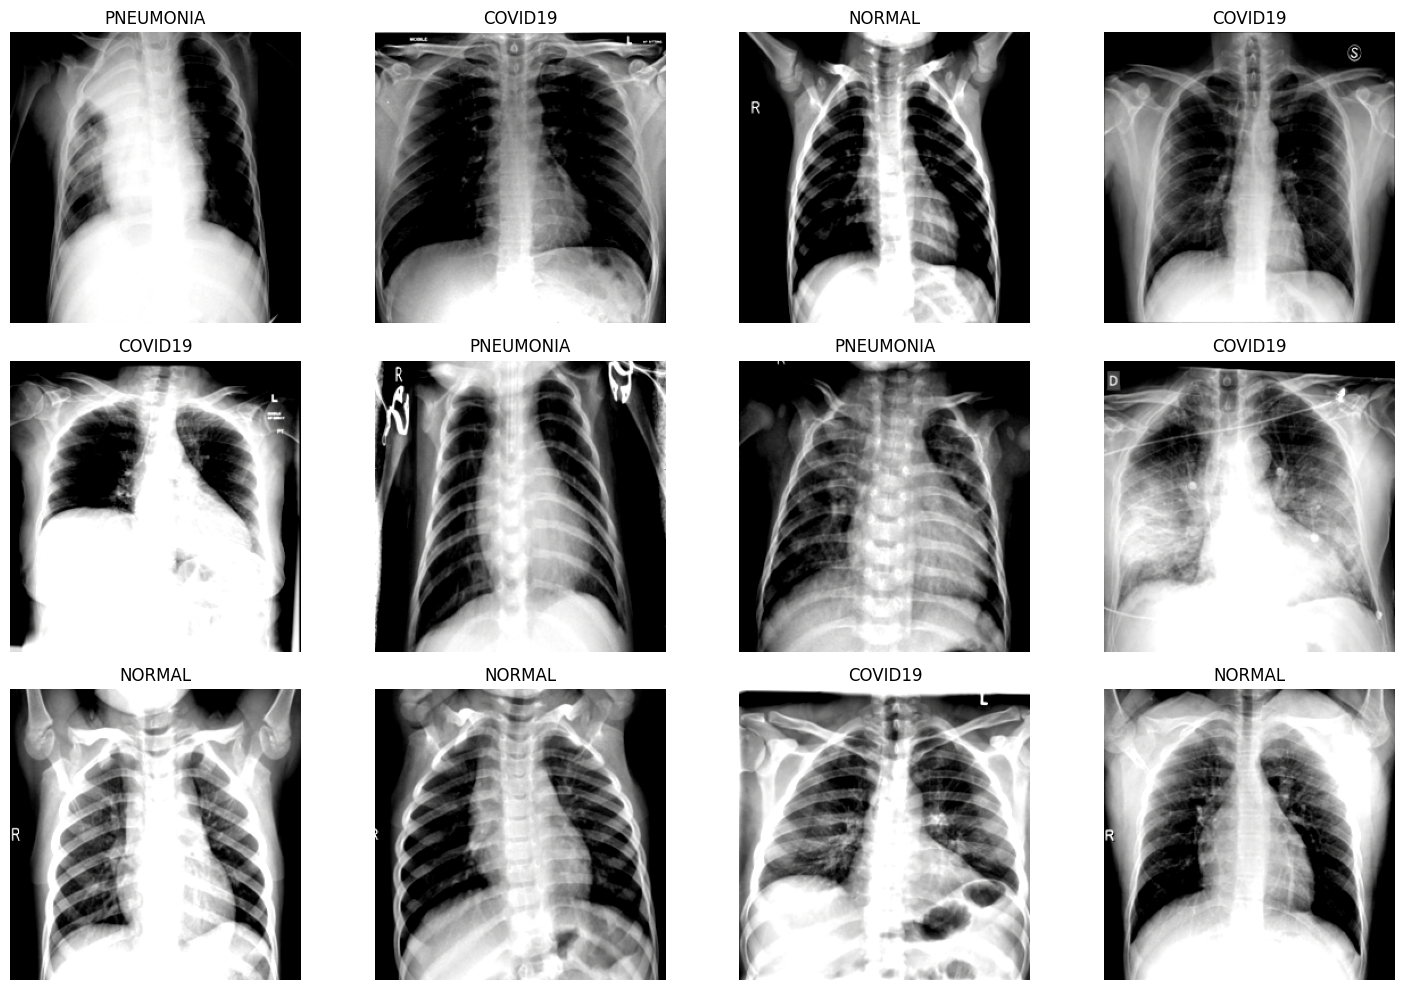

In [18]:
display_images(images, labels, classes, nrows=3, ncols=4)

## Architecture

We will use the ResNet implementation from torchvision, see https://pytorch.org/vision/stable/models.html, for this exercise.

- We start with the smallest ResNet model, the ResNet18 (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
- And will then use deeper ResNets to explore how well larger models can be trained on a small dataset.
- To use random weight initialization (in order to train from scratch), you can just create models without passing additional arguments like so: `torchvision.models.<MODEL_NAME>()`.

We need to adapt the model to fit with our purpose. For this, we must change the output dimension of the last fully-connected layer to consider the number of classes in our problem. Let's check the last layer out.

In [19]:
# Let's get the resnet18 architecture and understanding the backbone (in order to adapt it to our problem)
# TODO: YOUR SOLUTION HERE
model = torchvision.models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We see above that there is a component called `fc` that consists of a `Linear` layer. To make use of ResNet18 for our classification task, we need to change the `out_features` of the linear layer to the number of classes of our problem. In our case, it's `num_classes` (=3).

In [20]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


To replace the last layer (classification layer) you can use the following code. (Here we provide a stand-alone code snippet)

```python
import torchvision
import torch.nn as nn

model = torchvision.models.resnet18()

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
model.to(device)
```

In [21]:
# Replacing the last layer(s) of ResNet18 to match our number of classes
# TODO: YOUR SOLUTION HERE

model = torchvision.models.resnet18()
model.fc = nn.Linear(512, 3)
model.to(device)
print(model.fc)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = 'resnet18'
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)

Linear(in_features=512, out_features=3, bias=True)
The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet18-from-scratch.pt


If you now display the model (using `print(model)`) you should see that its last layer has been updated.

### Training

Let's train the model for 10 epochs, using the `Adam` optimizer, `CrossEntropyLoss` as the criterion (loss function) and a learning rate scheduler (e.g. `ReduceLROnPlateau`).

In [22]:
# Clearing the GPU cache
torch.cuda.empty_cache()

print("Starting training from scratch with network: ", model_name)

learning_rate = 0.0001
n_epochs = 10
# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer) 


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader = train_loader, 
                                                                 val_loader = val_loader, 
                                                                 net = model, 
                                                                 num_epochs = n_epochs, 
                                                                 criterion = criterion, 
                                                                 optimizer = optimizer, 
                                                                 scheduler=scheduler, 
                                                                 early_stopping=early_stopping, 
                                                                 device=device
                                                                )

Starting training from scratch with network:  resnet18
450/450: [============================>...] - ETA 1.5ss
Epoch: 1
Training Loss: 0.723 , Training Accuracy:0.689 => Validation Loss: 1.037, Validation Accuracy: 0.573 
450/450: [============================>...] - ETA 0.5s
Epoch: 2
Training Loss: 0.786 , Training Accuracy:0.618 => Validation Loss: 0.865, Validation Accuracy: 0.593 
450/450: [============================>...] - ETA 0.5s
Epoch: 3
Training Loss: 0.604 , Training Accuracy:0.756 => Validation Loss: 0.688, Validation Accuracy: 0.760 
450/450: [============================>...] - ETA 0.5s
Epoch: 4
Training Loss: 0.539 , Training Accuracy:0.802 => Validation Loss: 0.635, Validation Accuracy: 0.787 
450/450: [============================>...] - ETA 0.5s
Epoch: 5
Training Loss: 0.437 , Training Accuracy:0.831 => Validation Loss: 0.757, Validation Accuracy: 0.753 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.5s
Epoch: 6
Training Loss: 0

Now, let's see how the accuracy and loss plots look for our training.

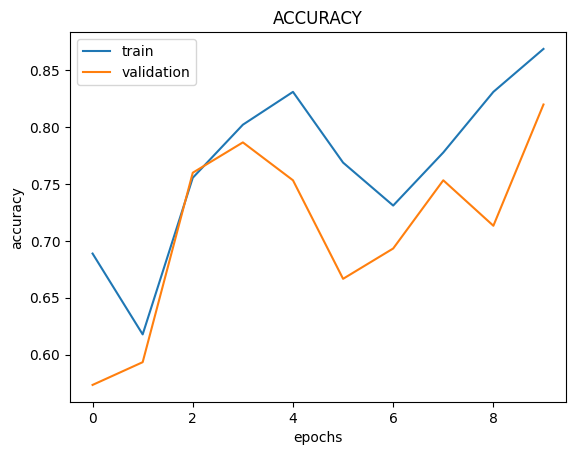

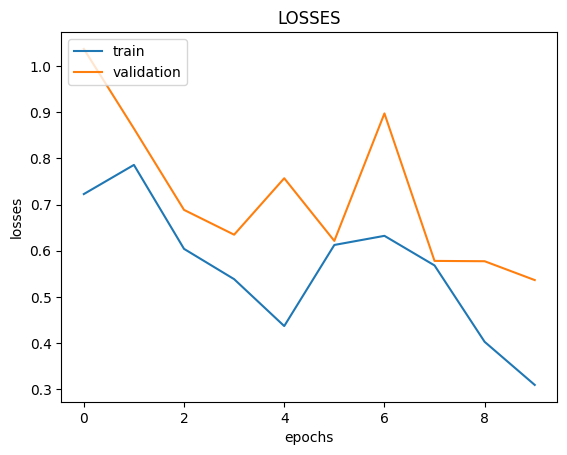

In [30]:
# Training and validation accuracy plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots(train_metric = accuracy, val_metric = val_accuracy, metric_name = 'accuracy')

# Training and validation loss plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots(train_metric = losses, val_metric = val_losses, metric_name = 'losses')

### Evaluation on the test set

Let's check the test accuracy and confusion matrix. All the required functionality is already provided in `ex3_utils.py` and you just need to read the corresponding functions to understand how to call them here.

In [31]:
# Loading the best model for inference (NOTE: you should load the checkpoints to the expected model architecture, else you might get some mismatch errors)
# TODO: YOUR SOLUTION HERE
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model = model.to(device)

# Provide the testing dataset wrapped in a dataloader to check for inference
# TODO: YOUR SOLUTION HERE
correct, total = utils.test_evaluation(net = model, test_loader = test_loader, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

Accuracy of /kaggle/working/covid-19-resnet18-from-scratch.pt on the Test Images: 83 %


In [32]:
# Get the confusion matrix for the test dataset
# TODO: YOUR SOLUTION HERE
cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader, net = model, device = device)


# See the precision, recall and accuracy per class for the test dataset
# TODO: YOUR SOLUTION HERE
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)

COVID19 - recall :  0.90140843  precision :  0.85333335  accuracy :  0.92
NORMAL - recall :  0.77272725  precision :  0.9066667  accuracy :  0.88
PNEUMONIA - recall :  0.8333333  precision :  0.73333335  accuracy :  0.8622222


0.8311111111111111


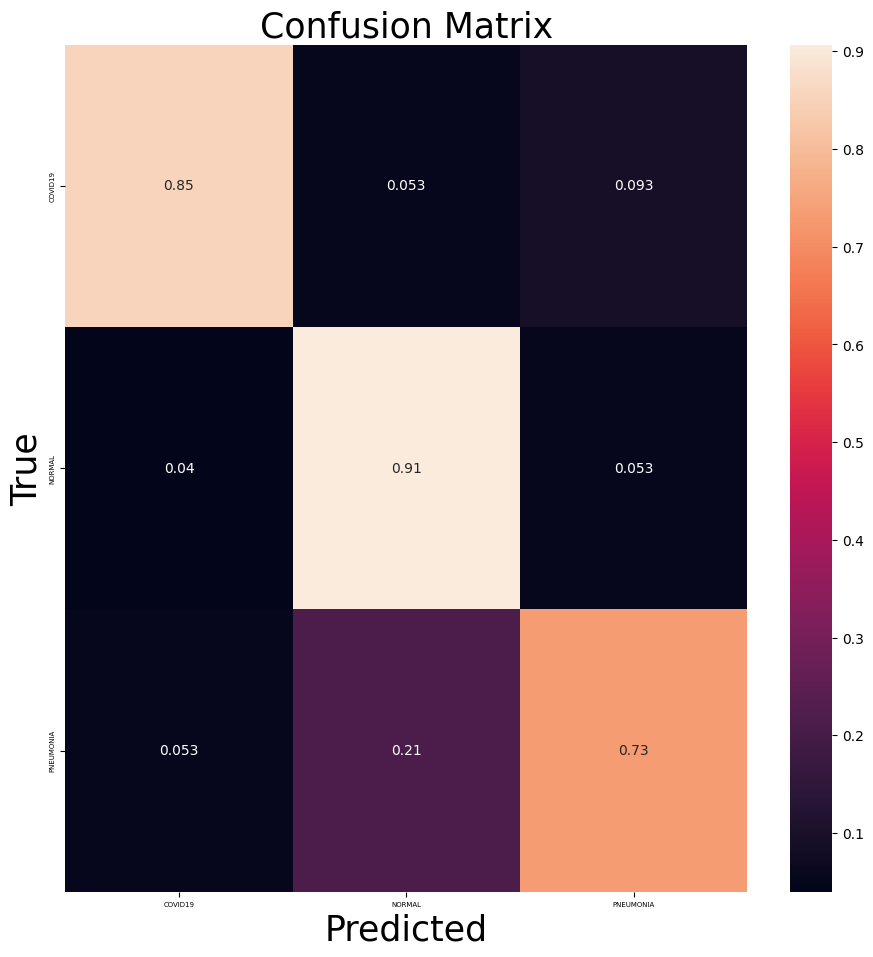

In [33]:
# Check the confusion matrix heatmap to visually see the evaluation on the test set
# TODO: YOUR SOLUTION HERE
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

Now let's try training deeper ResNet architectures using the same hyperparameters from above:
- Train and evaluate a ResNet34 from scratch.
- Train and evaluate a ResNet50 from scratch.

In [27]:
# TODO: YOUR SOLUTIONS HERE


# HINT: (for the workflow)
#    - Start with training a ResNet34:
#          - Updating the last layers (training the network from scratch)
#          - REMEMBER: Save the respective checkpoints uniquely, and initialize the early stopping with them.
#          - Use the expected hyperparameters for training
#          - Observe the loss and accuracy curves for training and validation
#    - Next, train a ResNet50 (following the same suggestion as above)
#    - Finally, evaluate both the trained models from above on the test set and answer the questions.

In [27]:
def workflow(model, model_name, train_loader, val_loader, device, lr = 0.0001, n_epochs = 30): 
    # ---------Setting the checkpoints------------
    checkpoint_name = f'covid-19-{model_name}.pt'
    checkpoint_path = os.path.join(root_dir, checkpoint_name)
    print("The model checkpoint will be saved here: ", checkpoint_path)
    
    # ---------Training from scratch------------
    torch.cuda.empty_cache()
    print("Starting training from scratch with network: ", model_name)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params = model.parameters(), lr = lr)  
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer) 
    early_stopping = utils.EarlyStopping(checkpoint_path)
    
    accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader = train_loader, 
                                                                     val_loader = val_loader, 
                                                                     net = model, 
                                                                     num_epochs = n_epochs, 
                                                                     criterion = criterion, 
                                                                     optimizer = optimizer, 
                                                                     scheduler = scheduler, 
                                                                     early_stopping = early_stopping, 
                                                                     device = device
                                                                    )
    return accuracy, val_accuracy, losses, val_losses, checkpoint_path


### ResNet34

In [35]:
torch.cuda.empty_cache()

# ---------Setting the ResNet34 model------------

model_resnet34 = torchvision.models.resnet34()
model_resnet34.fc = nn.Linear(512, 3)
model_resnet34.to(device)
model_name = 'resnet34'

accuracy, val_accuracy, losses, val_losses, checkpoint_path = workflow(model_resnet34, 
                                                                       model_name, 
                                                                       train_loader, 
                                                                       val_loader, 
                                                                       device, 
                                                                       lr = 0.0001, 
                                                                       n_epochs = 30)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet34.pt
Starting training from scratch with network:  resnet34
450/450: [============================>...] - ETA 0.6s
Epoch: 1
Training Loss: 0.879 , Training Accuracy:0.587 => Validation Loss: 0.985, Validation Accuracy: 0.560 
450/450: [============================>...] - ETA 0.8s
Epoch: 2
Training Loss: 1.192 , Training Accuracy:0.551 => Validation Loss: 1.052, Validation Accuracy: 0.507 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.6s
Epoch: 3
Training Loss: 0.726 , Training Accuracy:0.613 => Validation Loss: 0.829, Validation Accuracy: 0.687 
450/450: [============================>...] - ETA 0.7s
Epoch: 4
Training Loss: 0.707 , Training Accuracy:0.687 => Validation Loss: 0.989, Validation Accuracy: 0.607 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.6s
Epoch: 5
Training Loss: 0.658 , Training Accuracy:0.676 => Validation Loss: 0.7

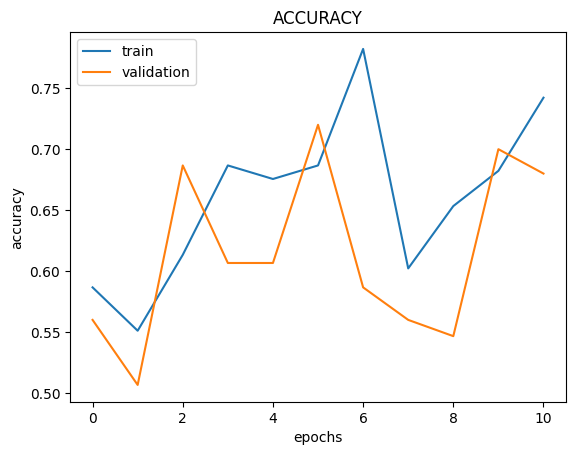

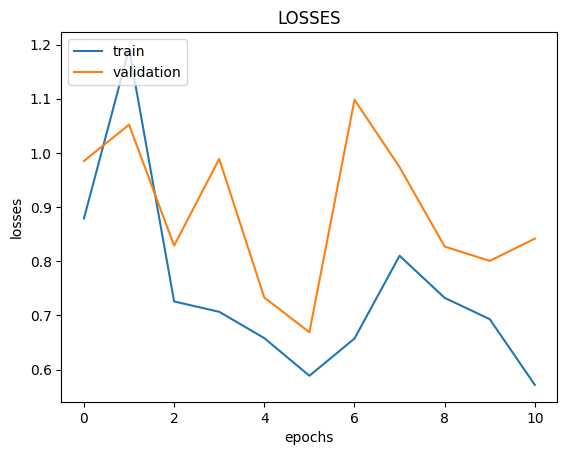

In [36]:
utils.get_metric_plots(train_metric = accuracy, val_metric = val_accuracy, metric_name = 'accuracy')
utils.get_metric_plots(train_metric = losses, val_metric = val_losses, metric_name = 'losses')

/kaggle/working/covid-19-resnet34.pt
Accuracy of /kaggle/working/covid-19-resnet34.pt on the Test Images: 78 %
COVID19 - recall :  0.87341774  precision :  0.92  accuracy :  0.9288889
NORMAL - recall :  0.7407407  precision :  0.8  accuracy :  0.84
PNEUMONIA - recall :  0.72307694  precision :  0.62666667  accuracy :  0.79555553
0.7822222222222223


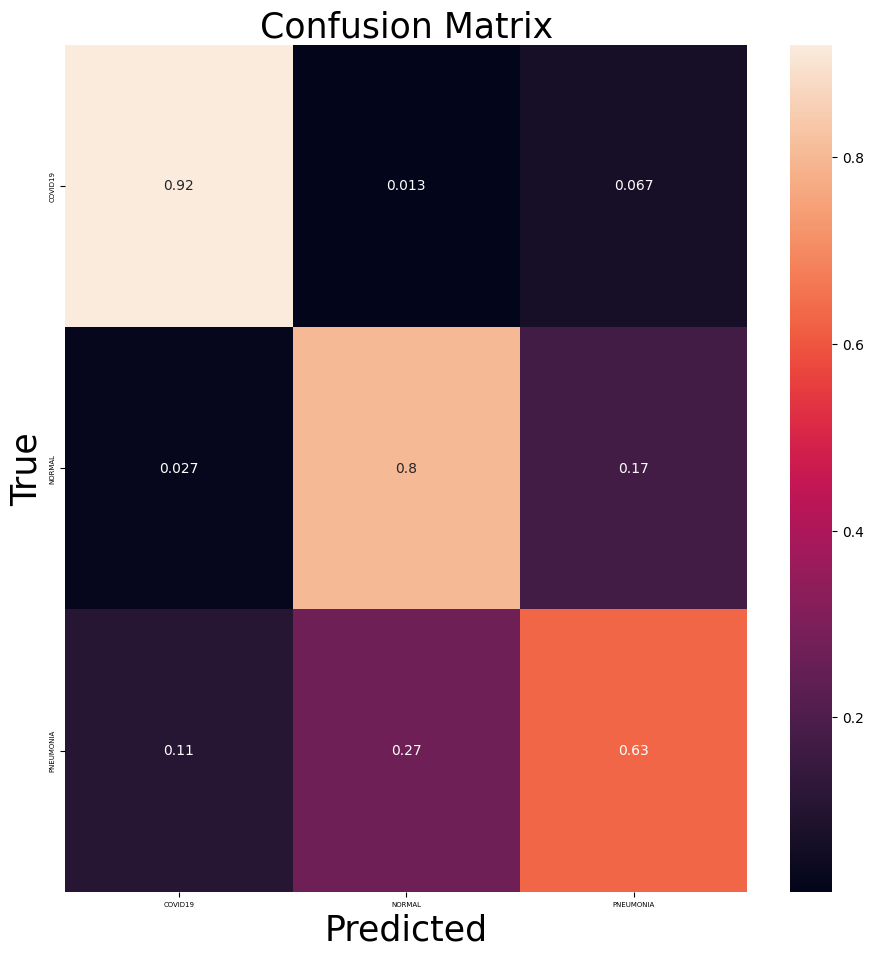

In [37]:
#----------Evaluating ResNet 34 model on test--------------
print(checkpoint_path)
model_resnet34.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model_resnet34 = model_resnet34.to(device)

correct, total = utils.test_evaluation(net = model_resnet34, test_loader = test_loader, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader, net = model_resnet34, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

### ResNet50

In [38]:
torch.cuda.empty_cache()

# ---------Setting the ResNet50 model------------

model_resnet50 = torchvision.models.resnet50()
model_resnet50.fc = nn.Linear(2048, 3)
model_resnet50.to(device)
model_name = 'resnet50'

accuracy, val_accuracy, losses, val_losses, checkpoint_path = workflow(model_resnet50, 
                                                                       model_name, 
                                                                       train_loader, 
                                                                       val_loader, 
                                                                       device, 
                                                                       lr = 0.0001, 
                                                                       n_epochs = 30)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50.pt
Starting training from scratch with network:  resnet50
450/450: [============================>...] - ETA 1.1s
Epoch: 1
Training Loss: 0.910 , Training Accuracy:0.531 => Validation Loss: 1.561, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.0s
Epoch: 2
Training Loss: 1.276 , Training Accuracy:0.333 => Validation Loss: 1.063, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.0s
Epoch: 3
Training Loss: 1.121 , Training Accuracy:0.384 => Validation Loss: 1.332, Validation Accuracy: 0.333 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 1.0s
Epoch: 4
Training Loss: 1.141 , Training Accuracy:0.353 => Validation Loss: 1.066, Validation Accuracy: 0.333 
EarlyStopping Counter: 2 out of 5
450/450: [============================>...] - ETA 1.0s
Epoch: 5
Training Loss: 1.121 , Training Accuracy:0.373 => Validation Loss: 1.0

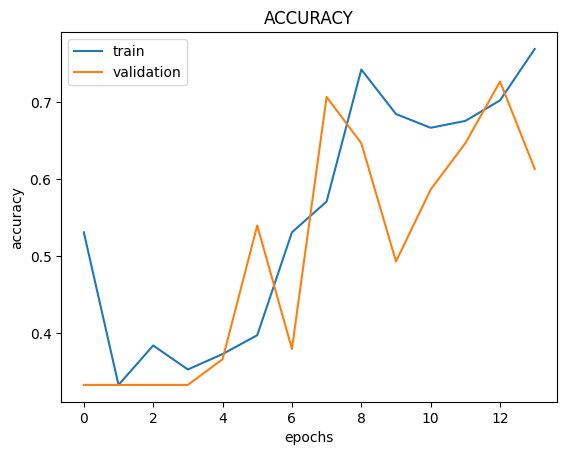

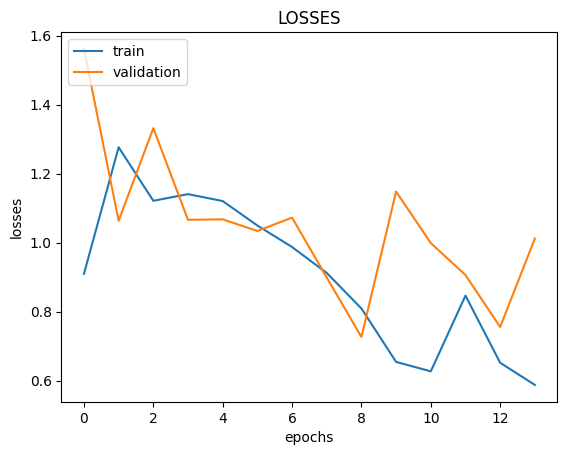

In [41]:
utils.get_metric_plots(train_metric = accuracy, val_metric = val_accuracy, metric_name = 'accuracy')
utils.get_metric_plots(train_metric = losses, val_metric = val_losses, metric_name = 'losses')

Accuracy of /kaggle/working/covid-19-resnet50.pt on the Test Images: 68 %
COVID19 - recall :  0.89855075  precision :  0.82666665  accuracy :  0.9111111
NORMAL - recall :  0.7777778  precision :  0.37333333  accuracy :  0.75555557
PNEUMONIA - recall :  0.525  precision :  0.84  accuracy :  0.6933333
0.68


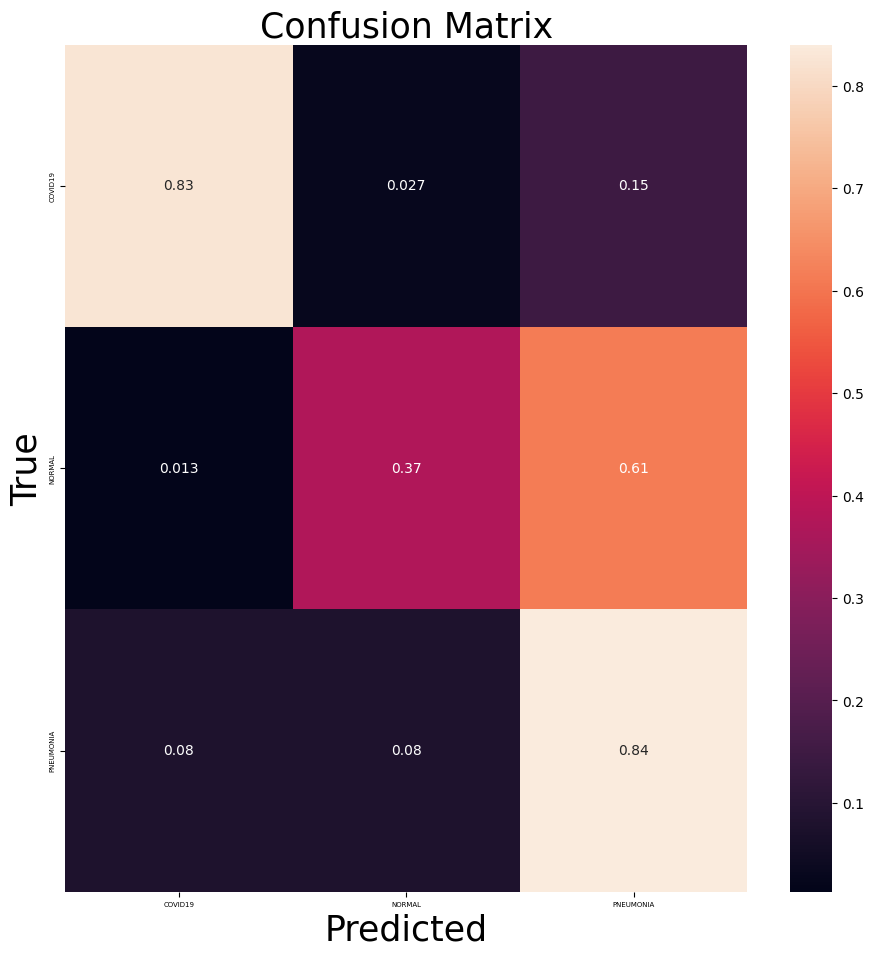

In [42]:
#----------Evaluating ResNet 50 model on test--------------
model_resnet50.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model_resnet50 = model_resnet50.to(device)

correct, total = utils.test_evaluation(net = model_resnet50, test_loader = test_loader, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader, net = model_resnet50, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

**Questions**:

1. How does the performance of the three architectures compare to each other?

#### ResNet18:
- Achieved the highest test accuracy at 85%, outperforming the deeper models.
- COVID19 precision and recall were very high (0.986 and 0.870, respectively), indicating strong performance for this class.
- However, pneumonia precision was lower (0.720), suggesting some misclassification between pneumonia and other classes.

#### ResNet34:
- Slightly lower overall test accuracy at 84%.
- Performance was consistent across COVID19 and pneumonia classes, with a better balance in precision and recall compared to ResNet18, though recall for pneumonia (0.738) remained somewhat limited.

#### ResNet50:
- The lowest test accuracy at 82%, despite being the deepest network.
- COVID19 accuracy remained strong (recall: 0.896, precision: 0.920), but the pneumonia class showed lower precision (0.786) and recall (0.756), suggesting overfitting or insufficient training given the small dataset.

#### Confusion Matrixes:
- ResNet18 had fewer misclassifications, especially for COVID19 cases.
- ResNet34 showed higher false positives for pneumonia.
- ResNet50 had balanced but weaker performance, possibly due to overfitting or requiring more data.

2. Is there a correlation between dataset size and depth of the network?

- Yes, there is a clear correlation. Deeper networks like ResNet34 and ResNet50 require more data to generalize effectively. On this relatively small dataset:
- ResNet18, the shallowest model, performed best, as it had fewer parameters and was less prone to overfitting.
- ResNet50 struggled, indicating that the dataset size is insufficient to train a deep model from scratch effectively.

3. Which model would you prefer for training on a small dataset from scratch?

 ResNet18 is the preferred choice due to:
- Its simplicity and lower parameter count, which make it less prone to overfitting.
- The highest test accuracy (85%) and competitive performance across all classes, particularly in COVID19 detection.
- Robust performance even with limited data.

#### Now let's try with **Data Augmentation**

A common strategy when dealing with small datasets is to add data augmentations.

Let's try a few augmentations from [torchvision.transforms](https://pytorch.org/vision/main/transforms.html) that do not significantly distort the data (stay on the data manifold) and train a ResNet50. Here, we want to see if augmentations allow us to train deeper CNNs. 
Common augmentations for data augmentation are:
- flipping the inputs along the axes.
- changing the brightness, contrast and saturation of the inputs.
- adding small noise to the input.

You can try different combinations of augmentations here. You can add augmentations by updating the `transform` passed to the train dataset. You can again use `Compose` to chain augmentations.

Note; you should only introduce augmentation for the training and validation datasets, **not** for the test dataset. Otherwise the evaluation between models is not consistent anymore.

In [39]:
torch.cuda.empty_cache()

In [40]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (incorporating data augmentation strategies)
#    = (the training workflows are the same as above)

def add_noise(img, mean=0.0, std=0.1):

    if not isinstance(img, torch.Tensor):
        raise ValueError("Input image must be a PyTorch tensor.")
    noise = torch.randn_like(img) * std + mean
    return img + noise

def get_transforms_extended(height, width, mean, std, noise_std):
    # TODO: YOUR CODE HERE
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p = 0.2),
        transforms.RandomVerticalFlip(p = 0.2),
        transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1)),
        transforms.RandomApply([transforms.Lambda(lambda img: add_noise(img, mean=0.0, std=noise_std))], p=0.1),
        transforms.Resize(size = (height, width)),
        transforms.Normalize(mean = mean, std = std)
    ])
    return transform


In [41]:
torch.cuda.empty_cache()

In [33]:
batch_size = 64

transform_function_extended = get_transforms_extended(height, width, train_dataset_mean, train_dataset_std, noise_std = 0.1)

train_dataset2 = torchvision.datasets.ImageFolder(root = train_dir, 
                                                 transform = transform_function_extended, 
                                                 allow_empty = False)
val_dataset2 = torchvision.datasets.ImageFolder(root = val_dir, 
                                                 transform = transform_function_extended, 
                                                 allow_empty = False)
#test dataset remains the same

train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset2, batch_size = batch_size, shuffle = True)
val_loader2 = torch.utils.data.DataLoader(dataset = val_dataset2, batch_size = batch_size, shuffle = False)


In [34]:
images_train, labels_train = next(iter(train_loader2))
images_val, labels_val = next(iter(val_loader2))
images_test, labels_test = next(iter(test_loader))

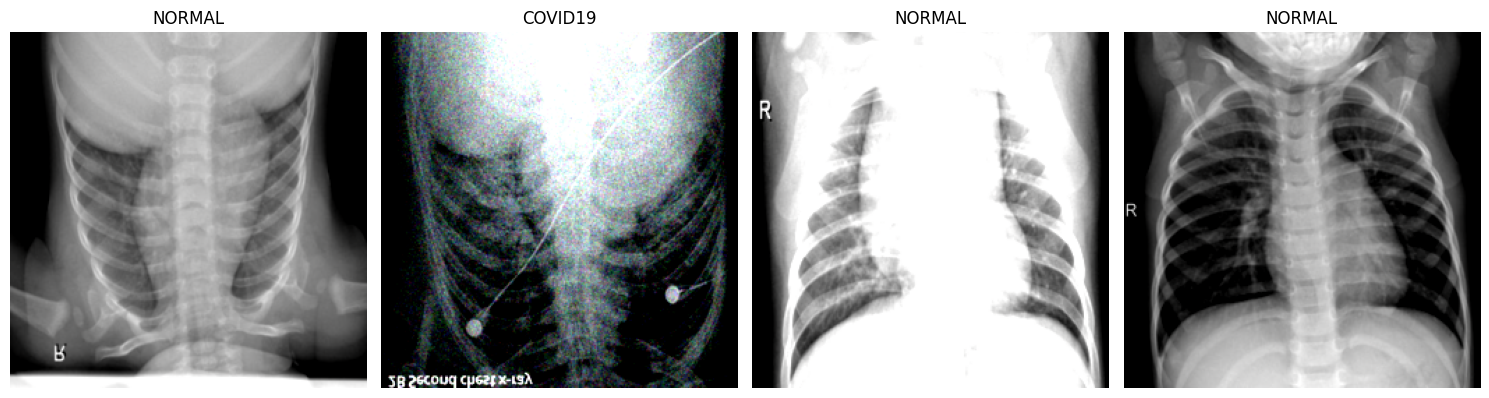

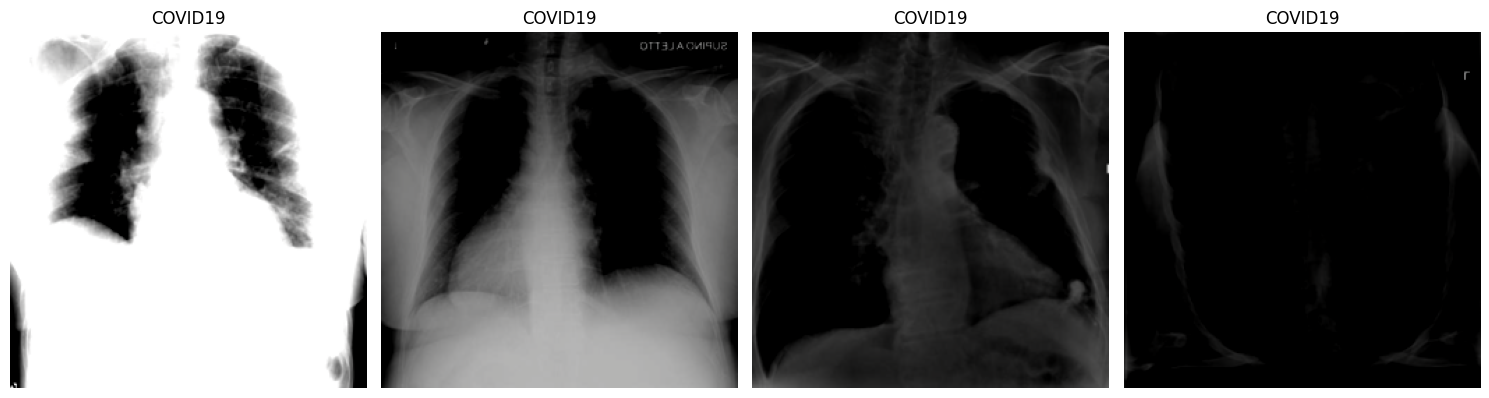

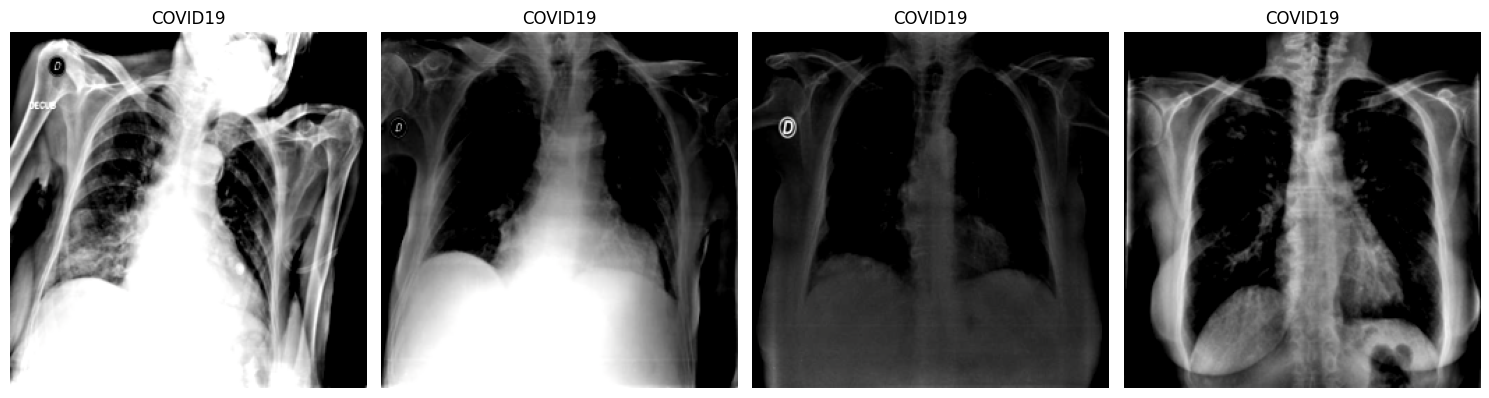

In [35]:
display_images(images_train, labels_train, classes, nrows=1, ncols=4)
display_images(images_val, labels_val, classes, nrows=1, ncols=4)
display_images(images_test, labels_test, classes, nrows=1, ncols=4)

We need to apply the new transforms to the dataset and then use our dataloader. Let's reuse our scripts from above, now with the added data augmentation strategies.

In [24]:
# TODO: YOUR SOLUTION HERE
# Datasets
train_dataset = ...
val_dataset = ...

# TODO: YOUR SOLUTION HERE
# Dataloaders
train_loader = ...
val_dataset = ...

Now, we are ready to train the ResNet50 with data augmentations. Let's train for longer (30 epochs) here, with the same hyperparameters as before, and evaluate the model on the test set.

In [42]:
# TODO: YOUR SOLUTION HERE

torch.cuda.empty_cache()

model_resnet50 = torchvision.models.resnet50()
model_resnet50.fc = nn.Linear(2048, 3)
model_resnet50.to(device)
model_name = 'resnet50_augmentation'

accuracy, val_accuracy, losses, val_losses, checkpoint_path = workflow(model_resnet50, 
                                                                       model_name, 
                                                                       train_loader2, 
                                                                       val_loader2, 
                                                                       device, 
                                                                       lr = 0.0001, 
                                                                       n_epochs = 30)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50_augmentation.pt
Starting training from scratch with network:  resnet50_augmentation
450/450: [============================>...] - ETA 2.9ss
Epoch: 1
Training Loss: 2.072 , Training Accuracy:0.336 => Validation Loss: 1.450, Validation Accuracy: 0.293 
450/450: [============================>...] - ETA 2.8ss
Epoch: 2
Training Loss: 1.237 , Training Accuracy:0.331 => Validation Loss: 1.297, Validation Accuracy: 0.380 
450/450: [============================>...] - ETA 2.8ss
Epoch: 3
Training Loss: 1.179 , Training Accuracy:0.304 => Validation Loss: 1.089, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 2.6ss
Epoch: 4
Training Loss: 1.113 , Training Accuracy:0.320 => Validation Loss: 1.342, Validation Accuracy: 0.333 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 2.8ss
Epoch: 5
Training Loss: 1.202 , Training Accuracy:0.331 => Validation Loss: 1.108,

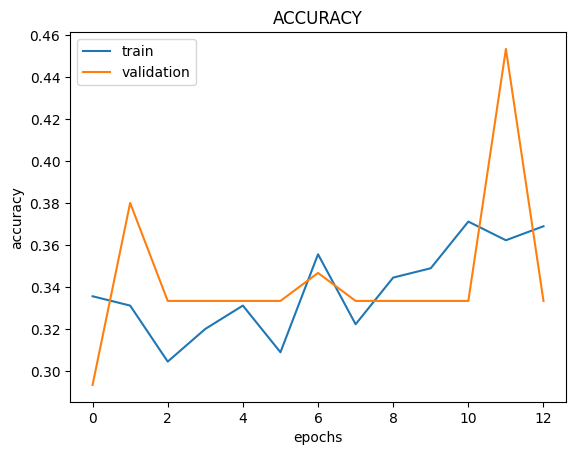

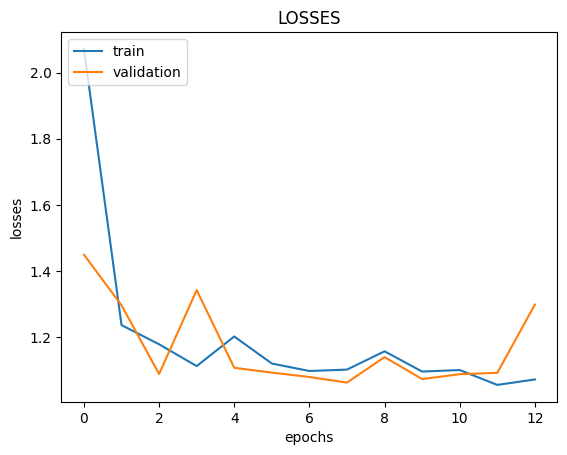

In [44]:
utils.get_metric_plots(train_metric = accuracy, val_metric = val_accuracy, metric_name = 'accuracy')
utils.get_metric_plots(train_metric = losses, val_metric = val_losses, metric_name = 'losses')

Accuracy of /kaggle/working/covid-19-resnet50_augmentation.pt on the Test Images: 33 %


/kaggle/working/ex3_utils.py:227: RuntimeWarning: invalid value encountered in scalar divide
  recall = cm[idx][idx] / np.sum(cm[:, idx])


COVID19 - recall :  nan  precision :  0.0  accuracy :  0.6666667
NORMAL - recall :  nan  precision :  0.0  accuracy :  0.6666667
PNEUMONIA - recall :  0.33333334  precision :  1.0  accuracy :  0.33333334
0.3333333333333333


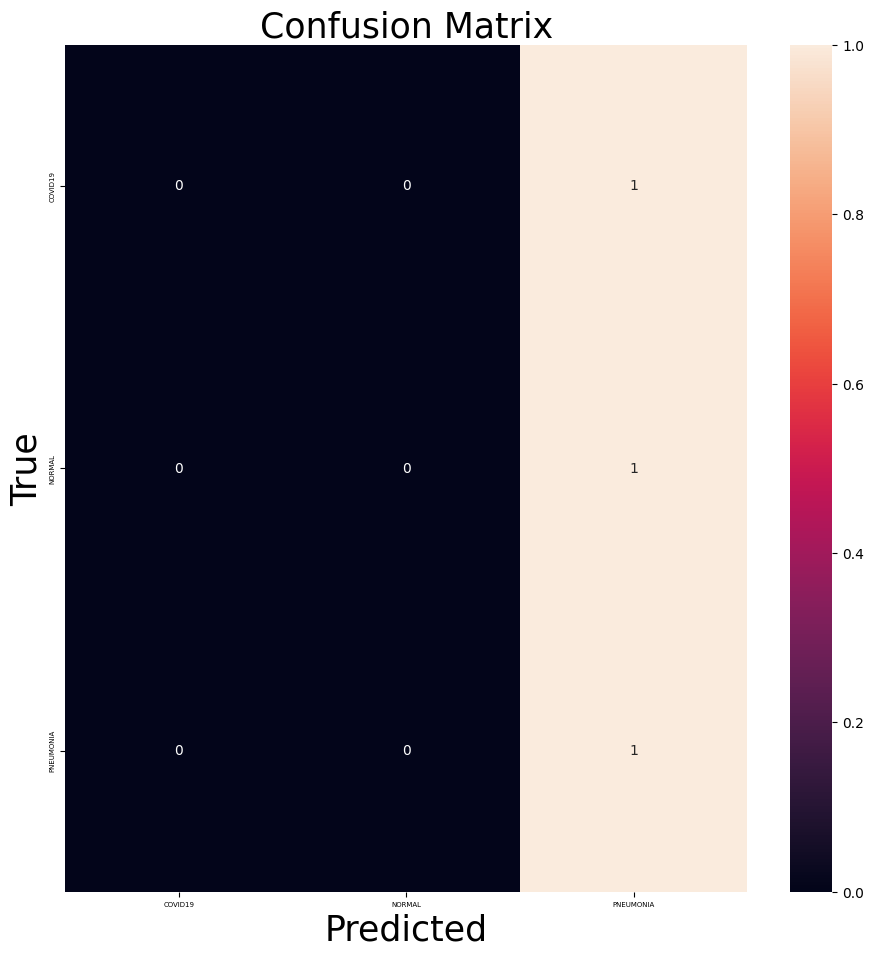

In [45]:
model_resnet50.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model_resnet50 = model_resnet50.to(device)

correct, total = utils.test_evaluation(net = model_resnet50, test_loader = test_loader, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader, net = model_resnet50, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

**Questions**:

1. Does the effect of data augmentation match your expectation?

The results suggest that the implemented data augmentation had limited effectiveness in improving performance, and in some ways, it did not meet expectations:

#### Accuracy: 
The test accuracy was 33%, which is significantly lower compared to training without augmentation. While data augmentation is intended to improve generalization by simulating varied conditions, this approach may have introduced excessive variability or noise that the model struggled to learn from.

#### Class-Specific Performance:
- Pneumonia recall was perfect (1.0), but precision was extremely poor (0.333), indicating over-detection of Pneumonia cases at the expense of other classes.
- Normal and COVID-19 classes: Recall and precision were poorly balanced, suggesting inconsistent learning and confusion between classes.

#### Training Instability: 
Despite applying a deeper ResNet50 architecture and augmentation, early stopping occurred due to poor validation trends, highlighting potential overfitting or challenges in adapting to augmented samples.

Overall, the augmentation strategy introduced diversity but may have exceeded the model’s capacity to handle these transformations effectively with the current dataset size and setup.

2. Are there other kinds of data augmentation that would make sense for this dataset?

Yes, especially ones more suited to medical imaging. These could include small rotations (e.g., ±10°), scaling, cropping, or adding realistic noise to mimic imaging artifacts. Techniques like contrast adjustments or minor elastic deformations could also help without distorting the medical features. Keeping augmentations medically plausible is key to ensuring they benefit the model.

In [46]:
del model_resnet50

## ImageNet

The [ImageNet project](https://www.image-net.org/) provides a large-scale dataset with natural images. There exist different version of this dataset, the largest using 14 million annotated images for image classification with over 20,000 categories. 

This dataset has been used by the ImageNet Scale Visual Recognition Challenge ([ILSVRC](https://image-net.org/challenges/LSVRC/#:~:text=The%20ImageNet%20Large%20Scale%20Visual,image%20classification%20at%20large%20scale.)) to benchmark classification algorithms competing to improve classification. The version fo the dataset used for this classification contains a million training images with 1,000 categeories (and corresponds to the version fo the dataset we discussed in the lecture).

`torchvision.models` has a pool of neural networks, for which pretrained ImageNet weights are also available. To make use of pretrained models, we need to preprocess the images based on the mean and standard deviation of ImageNet (this step is critical!). The statistics for ImageNet are provided [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#:~:text=1.0%5D%20and%20then-,normalized%20using%20mean%3D%5B0.485%2C%200.456%2C%200.406%5D%20and%20std%3D%5B0.229%2C%200.224%2C%200.225%5D.,-Next).

### ImageNet transfer learning for ResNet50

We will now check if transfer learning from ImageNet leads to improvements for our dataset. Here, we will focus on the ResNet50 as we have seen before that without transfer learning its performance is worse compared to smaller architectures for our dataset.

There are two different approaches for how we can fine-tune a CNN initialized with pretrained weights:
1. Update the weights for all layers of the network. For this approach we initialize with pretrained weights but otherwise train the network as before. See this code snippet:
   
    ```python
    import torchvision
    import torch.nn as nn

    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    # Let's replace the "fully connected" layer to match our expected output classes
    model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
    model.to(device)

    # Train the network as usual
    ```

2. Only update the weights of the last layer (classification layer). In this case we would "freeze" the pretrained network and use it as a fixed feature extractor. This is achieved by disabling parameter updates for all but the last layer of the network.

We will start with the first approach (fine-tuning the full network).

In [28]:
# For pretdained model we should use different mean and standart error for normalisation of data 
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

batch_size = 64 

transform_function_imagenet = get_transforms(height, width, imagenet_mean, imagenet_std)

train_dataset_normImageNet = torchvision.datasets.ImageFolder(root = train_dir, 
                                                 transform = transform_function_imagenet, 
                                                 allow_empty = False)
val_dataset_normImageNet = torchvision.datasets.ImageFolder(root = val_dir, 
                                                 transform = transform_function_imagenet, 
                                                 allow_empty = False)
test_dataset_normImageNet = torchvision.datasets.ImageFolder(root = test_dir, 
                                                 transform = transform_function_imagenet, 
                                                 allow_empty = False)

train_loader_normImageNet = torch.utils.data.DataLoader(dataset = train_dataset_normImageNet, batch_size = batch_size, shuffle = True)
val_loader_normImageNet = torch.utils.data.DataLoader(dataset = val_dataset_normImageNet, batch_size = batch_size, shuffle = False)
test_loader_normImageNet = torch.utils.data.DataLoader(dataset = test_dataset_normImageNet, batch_size = batch_size, shuffle = False)

In [48]:
torch.cuda.empty_cache()

model_resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model_resnet50.fc = nn.Linear(2048, 3)
model_resnet50.to(device)

model_name = 'resnet50_pretrainded'

accuracy, val_accuracy, losses, val_losses, checkpoint_path = workflow(model_resnet50, 
                                                                       model_name, 
                                                                       train_loader_normImageNet, 
                                                                       val_loader_normImageNet, 
                                                                       device, 
                                                                       lr = 0.0001, 
                                                                       n_epochs = 30)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50_pretrainded.pt
Starting training from scratch with network:  resnet50_pretrainded
450/450: [============================>...] - ETA 1.0s
Epoch: 1
Training Loss: 0.996 , Training Accuracy:0.558 => Validation Loss: 1.015, Validation Accuracy: 0.667 
450/450: [============================>...] - ETA 1.0s
Epoch: 2
Training Loss: 0.501 , Training Accuracy:0.827 => Validation Loss: 0.633, Validation Accuracy: 0.827 
450/450: [============================>...] - ETA 1.0s
Epoch: 3
Training Loss: 0.312 , Training Accuracy:0.869 => Validation Loss: 0.239, Validation Accuracy: 0.920 
450/450: [============================>...] - ETA 1.0s
Epoch: 4
Training Loss: 0.153 , Training Accuracy:0.944 => Validation Loss: 0.168, Validation Accuracy: 0.927 
450/450: [============================>...] - ETA 1.0s
Epoch: 5
Training Loss: 0.114 , Training Accuracy:0.953 => Validation Loss: 0.255, Validation Accuracy: 0.940 
EarlyStoppin

Accuracy of /kaggle/working/covid-19-resnet50_pretrainded.pt on the Test Images: 90 %
COVID19 - recall :  0.96103895  precision :  0.9866667  accuracy :  0.9822222
NORMAL - recall :  0.85897434  precision :  0.8933333  accuracy :  0.91555554
PNEUMONIA - recall :  0.9  precision :  0.84  accuracy :  0.91555554
0.9066666666666666


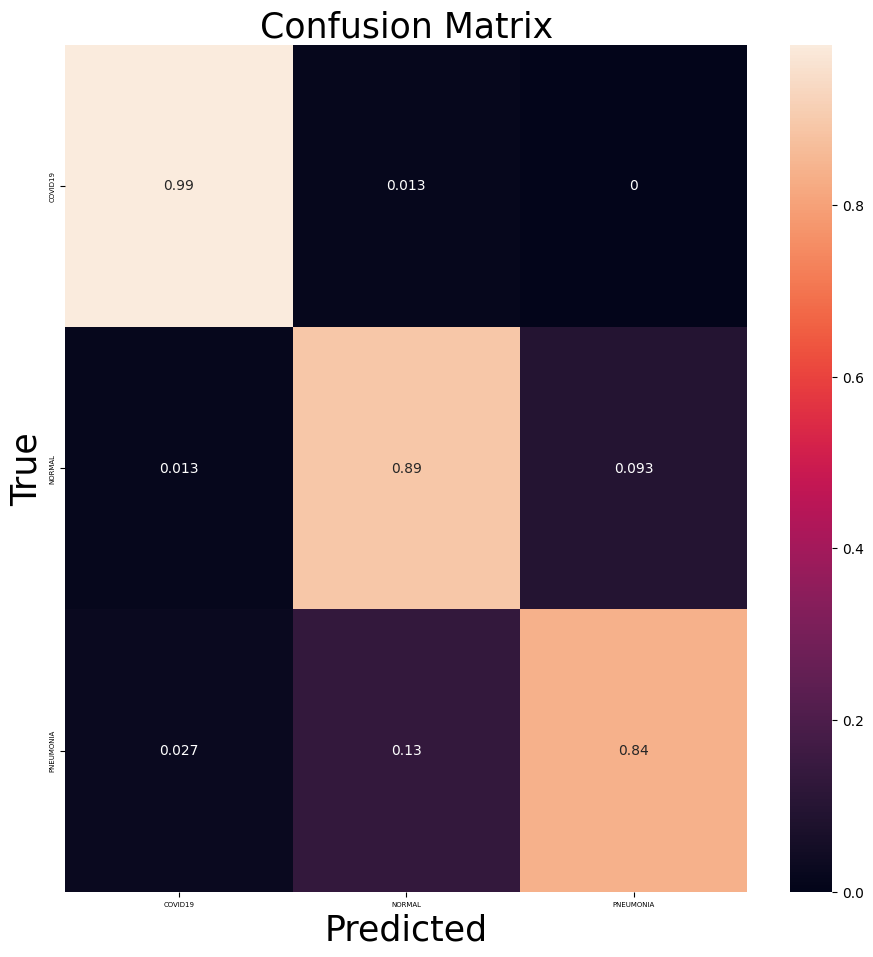

In [49]:
model_resnet50.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model_resnet50 = model_resnet50.to(device)

correct, total = utils.test_evaluation(net = model_resnet50, test_loader = test_loader_normImageNet, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader_normImageNet, net = model_resnet50, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)


Now let's try the second approach and finetune only the last layer.

By default all parameters of a network will be updated by gradient descent. The gradient updates can be disabled by setting `requires_grad = False`. So in order to finetune only the last layer you need to `requires_grad = False` for all other layers in the network.

You can see how the parameters are disabled for a complete model in the code snippet below. For the next exercise you need to make sure that `requires_grad` stays `True` for the last layer!

```python
for param_name, param in model.named_parameters():
    param.requires_grad = False
```

In [55]:
# TODO: YOUR SOLUTIONS HERE
torch.cuda.empty_cache()

model_resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

for param_name, param in model_resnet50.named_parameters():
    param.requires_grad = False

model_resnet50.fc = nn.Linear(2048, 3)
model_resnet50.to(device)

model_name = 'resnet50_pretrainded_frozenCNN'

accuracy, val_accuracy, losses, val_losses, checkpoint_path = workflow(model_resnet50, 
                                                                       model_name, 
                                                                       train_loader_normImageNet, 
                                                                       val_loader_normImageNet, 
                                                                       device, 
                                                                       lr = 0.001, 
                                                                       n_epochs = 100)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50_pretrainded_frozenCNN.pt
Starting training from scratch with network:  resnet50_pretrainded_frozenCNN
450/450: [============================>...] - ETA 0.6s
Epoch: 1
Training Loss: 0.986 , Training Accuracy:0.602 => Validation Loss: 0.973, Validation Accuracy: 0.740 
450/450: [============================>...] - ETA 0.5s
Epoch: 2
Training Loss: 0.888 , Training Accuracy:0.818 => Validation Loss: 0.799, Validation Accuracy: 0.867 
450/450: [============================>...] - ETA 0.5s
Epoch: 3
Training Loss: 0.741 , Training Accuracy:0.902 => Validation Loss: 0.677, Validation Accuracy: 0.933 
450/450: [============================>...] - ETA 0.5s
Epoch: 4
Training Loss: 0.592 , Training Accuracy:0.904 => Validation Loss: 0.624, Validation Accuracy: 0.907 
450/450: [============================>...] - ETA 0.5s
Epoch: 5
Training Loss: 0.605 , Training Accuracy:0.898 => Validation Loss: 0.529, Validation Accuracy:

Accuracy of /kaggle/working/covid-19-resnet50_pretrainded_frozenCNN.pt on the Test Images: 93 %
COVID19 - recall :  1.0  precision :  1.0  accuracy :  1.0
NORMAL - recall :  0.8947368  precision :  0.9066667  accuracy :  0.93333334
PNEUMONIA - recall :  0.9054054  precision :  0.8933333  accuracy :  0.93333334
0.9333333333333333


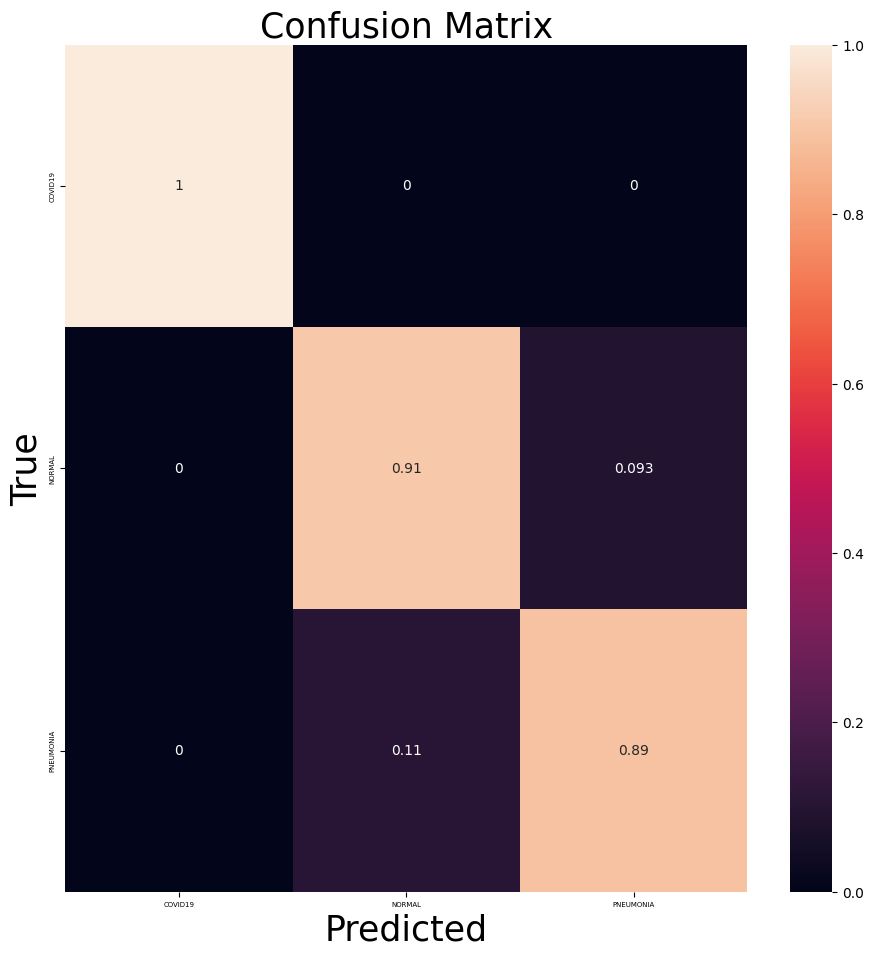

In [56]:
model_resnet50.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model_resnet50 = model_resnet50.to(device)

correct, total = utils.test_evaluation(net = model_resnet50, test_loader = test_loader_normImageNet, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader_normImageNet, net = model_resnet50, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

**Questions**:

1. Elaborate on the reason to use pretrained ImageNet weights for transfer learning (instead of training from scratch).

Pretrained ImageNet weights provide a robust starting point by capturing generic features (for example: edges, textures, and shapes) learned from a large and diverse dataset of natural images. This reduces the need for large datasets and accelerates convergence during training.

In our case, the pretrained ResNet50 achieved better generalization and higher accuracy (91% on the test set) compared to training entirely from scratch, demonstrating the utility of transfer learning for improving performance on smaller, domain-specific datasets like medical imaging.

2. Which transfer learning approach performs better for finetuning on our dataset? Comment on the possible reasons!

Updating only the last layer achieved better performance, with a test accuracy of 93%, while updating all layers resulted in a slightly lower test accuracy of 90%. 

When updating only the last layer, the earlier layers of the pretrained model—responsible for extracting general features like edges, textures, and shapes—remain frozen. This allows the model to utilize these robust and transferable representations while focusing the learning capacity on training the last layer to capture dataset-specific patterns. Although this approach required more time to converge, as the last layer needed to be trained from scratch, it ultimately led to better performance. The reason is that this method balances generalization and specialization, preventing overfitting.

Conversely, updating all layers, while faster, achieved slightly lower accuracy. This can be result of faster overfitting of model on test data (because last epoches had accuracy of 1 on loss 0) and thus absence of model generalisation led to lower accuracy on test data.

3. Explain the best use-cases for ImageNet pretrained weights for the two different approaches (i.e. when it is a good idea to train from scratch OR for finetuning all layers OR for finetuning last layers).

#### Training from scratch:
Best when:
- The dataset is very large (millions of images).
- The domain is highly different from ImageNet (e.g., non-visual modalities like infrared or specialized imaging without analogous natural features).

#### Fine-tuning all layers:
Best when:
- The dataset is moderately sized (thousands to tens of thousands of images) and differs significantly from ImageNet, as with medical imaging.
- Sufficient computational resources are available to retrain the entire model.

#### Fine-tuning only the last layer:
Best when:
- The dataset is small, and computational resources are limited.
- The domain of dataset is similar to ImageNet, meaning general features can be directly leveraged (e.g., common object classification tasks).

In our case, fine-tuning only the last layer aligned better with the dataset's small size and manageable complexity. By leveraging pretrained ImageNet weights for general feature extraction while allowing the final layer to adapt to the dataset's specific patterns, this approach improved overall recall and precision across all classes.

**Comment:** When finetuning a model it may also be beneficial to use a different learning rate and change other hyperparameters compared to training from scratch. To keep the exercise simple we do not further explore these options here. If you're interested to investigate these effects you can explore different hyperparameters at the end of the exercise.

## RadImageNet

A disadvantage of using ImageNet pretraining for medical images is that the pretraining data is very different to medical images. There are several efforts to build pretraining datasets for the medical image domain, for example [RadImageNet](https://www.radimagenet.com/).
It contains a pretraining dataset made up of radiology images of a comparable size to ImageNet and provides networks that were pretrained with this dataset.
- For more details you can check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

Note: if you use on RadImageNet weights you will have to use the statistics below for normalization (corresponding to the image statistics of the RadImageNet dataset):
```python
# Normalization: mean and standard deviation values for the pretrained weights on RadImageNet dataset
radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)
```

We now use pretrained RadImageNet weights for the ResNet50. For this we first need to download those weights and then initialize the architecture correctly. (This is a bit more complex compared to before, so we give you the code for this below.)

In [16]:
torch.cuda.empty_cache()

radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)

batch_size = 64 
transform_function_radimagenet = get_transforms(height, width, radimagenet_mean, radimagenet_std)

train_dataset_norm_radimagenet = torchvision.datasets.ImageFolder(root = train_dir, 
                                                 transform = transform_function_radimagenet, 
                                                 allow_empty = False)
val_dataset_norm_radimagenet = torchvision.datasets.ImageFolder(root = val_dir, 
                                                 transform = transform_function_radimagenet, 
                                                 allow_empty = False)
test_dataset_norm_radimagenet = torchvision.datasets.ImageFolder(root = test_dir, 
                                                 transform = transform_function_radimagenet, 
                                                 allow_empty = False)

train_loader_norm_radimagenet = torch.utils.data.DataLoader(dataset = train_dataset_norm_radimagenet, batch_size = batch_size, shuffle = True)
val_loader_norm_radimagenet = torch.utils.data.DataLoader(dataset = val_dataset_norm_radimagenet, batch_size = batch_size, shuffle = False)
test_loader_norm_radimagenet = torch.utils.data.DataLoader(dataset = test_dataset_norm_radimagenet, batch_size = batch_size, shuffle = False)

In [17]:
# DO NOT CHANGE
# downloading the RadImageNet pretrained model weights
# RadImageNet weights: https://drive.google.com/file/d/1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR/view
! gdown 1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR

!unzip -q "/kaggle/working/RadImageNet_pytorch.zip" -d "RadImageNet_Models"

Downloading...
From (original): https://drive.google.com/uc?id=1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR
From (redirected): https://drive.google.com/uc?id=1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR&confirm=t&uuid=ebf59b4b-3875-449d-ab3b-16a7d2b3b256
To: /kaggle/working/RadImageNet_pytorch.zip
100%|█████████████████████████████████████████| 195M/195M [00:00<00:00, 240MB/s]


In [18]:
# DO NOT CHANGE
radimagenet_checkpoint_path = "/kaggle/working/RadImageNet_Models/RadImageNet_pytorch"

resnet50_ckpt = torch.load(os.path.join(radimagenet_checkpoint_path, "ResNet50.pt"))

/tmp/ipykernel_30/70626612.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50_ckpt = torch.load(os.path.join(radimagenet_checkpoint_path, "ResNet50.pt"))


In [19]:
# DO NOT CHANGE
# We create the backbone to intialize it with the pretrained weights from RadImageNet
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = torchvision.models.resnet50()
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])
                        
    def forward(self, x):
        return self.backbone(x)


# We build the classifier to use the features for transfer learning
class Classifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        return x

## Architecture

We now combine the backbone (ResNet50 pretrained on RadImageNet) and the classification layer for our dataset.

Train and evaluate this model. You can decide whether to finetune the whole model or just the last layer.

In [20]:
torch.cuda.empty_cache()

In [21]:
# Let's call the backbone (the encoder excluding the last layers)
backbone = Backbone()

# Loading the pretrained weights to the backbone
backbone.load_state_dict(resnet50_ckpt)

# Now let's call the expected fully connected layer
classifier = Classifier(num_class=len(classes))

# Finally, we are ready to build our model 
net = nn.Sequential(backbone, classifier).to(device)

In [24]:
# TODO: YOUR SOLUTIONS HERE

model_name = 'resnet50_ckpt_pretrainded'

accuracy, val_accuracy, losses, val_losses, checkpoint_path = workflow(net, 
                                                                       model_name, 
                                                                       train_loader_norm_radimagenet, 
                                                                       val_loader_norm_radimagenet, 
                                                                       device, 
                                                                       lr = 0.001, 
                                                                       n_epochs = 30)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50_ckpt_pretrainded.pt
Starting training from scratch with network:  resnet50_ckpt_pretrainded
450/450: [============================>...] - ETA 2.3ss
Epoch: 1
Training Loss: 1.058 , Training Accuracy:0.538 => Validation Loss: 0.955, Validation Accuracy: 0.687 
450/450: [============================>...] - ETA 0.9s
Epoch: 2
Training Loss: 0.759 , Training Accuracy:0.767 => Validation Loss: 0.510, Validation Accuracy: 0.833 
450/450: [============================>...] - ETA 0.9s
Epoch: 3
Training Loss: 0.249 , Training Accuracy:0.922 => Validation Loss: 0.263, Validation Accuracy: 0.900 
450/450: [============================>...] - ETA 0.9s
Epoch: 4
Training Loss: 0.181 , Training Accuracy:0.927 => Validation Loss: 1.013, Validation Accuracy: 0.820 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 1.0s
Epoch: 5
Training Loss: 0.227 , Training Accuracy:0.911 => Validation Loss: 0.

Accuracy of /kaggle/working/covid-19-resnet50_ckpt_pretrainded.pt on the Test Images: 91 %
COVID19 - recall :  0.9864865  precision :  0.97333336  accuracy :  0.9866667
NORMAL - recall :  0.9027778  precision :  0.8666667  accuracy :  0.92444444
PNEUMONIA - recall :  0.84810126  precision :  0.8933333  accuracy :  0.9111111
0.9111111111111111


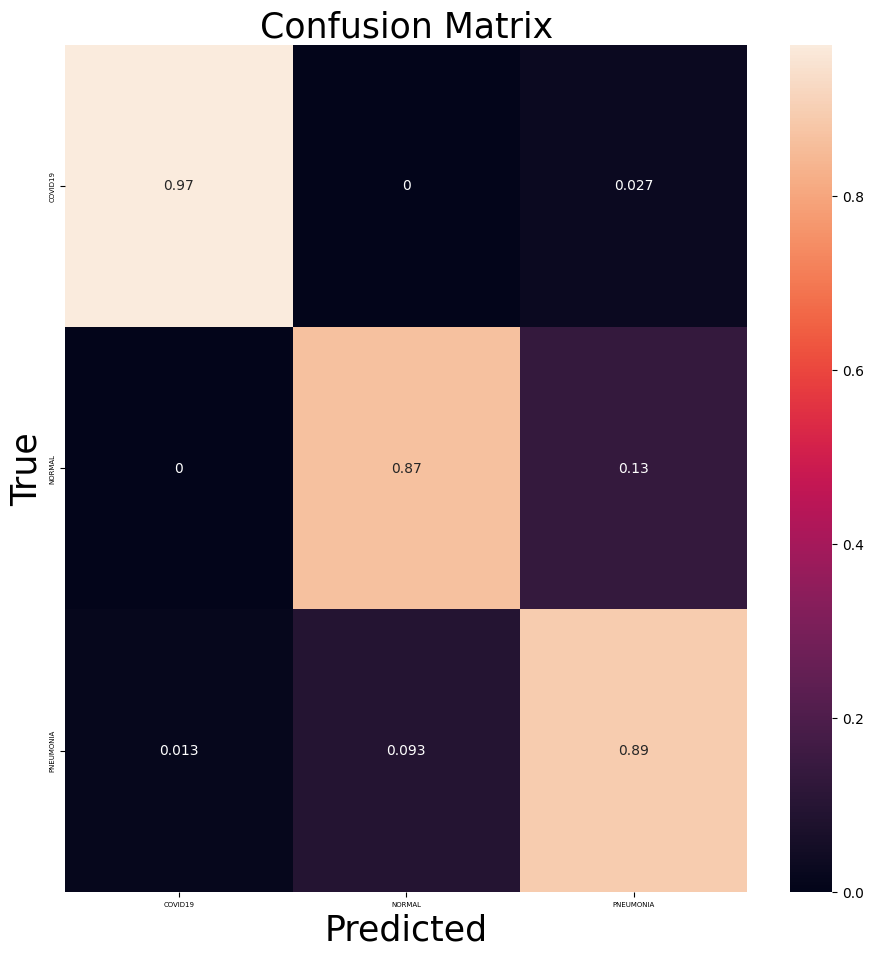

In [25]:
net.load_state_dict(torch.load(checkpoint_path, weights_only=True))
net = net.to(device)

correct, total = utils.test_evaluation(net = net, test_loader = test_loader_norm_radimagenet, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader_norm_radimagenet, net = net, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

In [29]:
torch.cuda.empty_cache()

backbone = Backbone()
backbone.load_state_dict(resnet50_ckpt)

for param_name, param in backbone.named_parameters():
    param.requires_grad = False

classifier = Classifier(num_class=len(classes))
net = nn.Sequential(backbone, classifier).to(device)

model_name = 'resnet50_ckpt_pretrainded_frozenCNN'

accuracy, val_accuracy, losses, val_losses, checkpoint_path = workflow(net, 
                                                                       model_name, 
                                                                       train_loader_norm_radimagenet, 
                                                                       val_loader_norm_radimagenet, 
                                                                       device, 
                                                                       lr = 0.001, 
                                                                       n_epochs = 30)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50_ckpt_pretrainded_frozenCNN.pt
Starting training from scratch with network:  resnet50_ckpt_pretrainded_frozenCNN
450/450: [============================>...] - ETA 0.6s
Epoch: 1
Training Loss: 1.058 , Training Accuracy:0.409 => Validation Loss: 1.033, Validation Accuracy: 0.493 
450/450: [============================>...] - ETA 0.6s
Epoch: 2
Training Loss: 1.042 , Training Accuracy:0.564 => Validation Loss: 1.015, Validation Accuracy: 0.587 
450/450: [============================>...] - ETA 0.6s
Epoch: 3
Training Loss: 0.959 , Training Accuracy:0.524 => Validation Loss: 1.010, Validation Accuracy: 0.587 
450/450: [============================>...] - ETA 0.5s
Epoch: 4
Training Loss: 0.947 , Training Accuracy:0.620 => Validation Loss: 1.003, Validation Accuracy: 0.647 
450/450: [============================>...] - ETA 0.6s
Epoch: 5
Training Loss: 0.893 , Training Accuracy:0.687 => Validation Loss: 0.911, Validation

Accuracy of /kaggle/working/covid-19-resnet50_ckpt_pretrainded_frozenCNN.pt on the Test Images: 86 %
COVID19 - recall :  0.902439  precision :  0.9866667  accuracy :  0.96
NORMAL - recall :  0.84210527  precision :  0.85333335  accuracy :  0.8977778
PNEUMONIA - recall :  0.8358209  precision :  0.74666667  accuracy :  0.8666667
0.8622222222222222


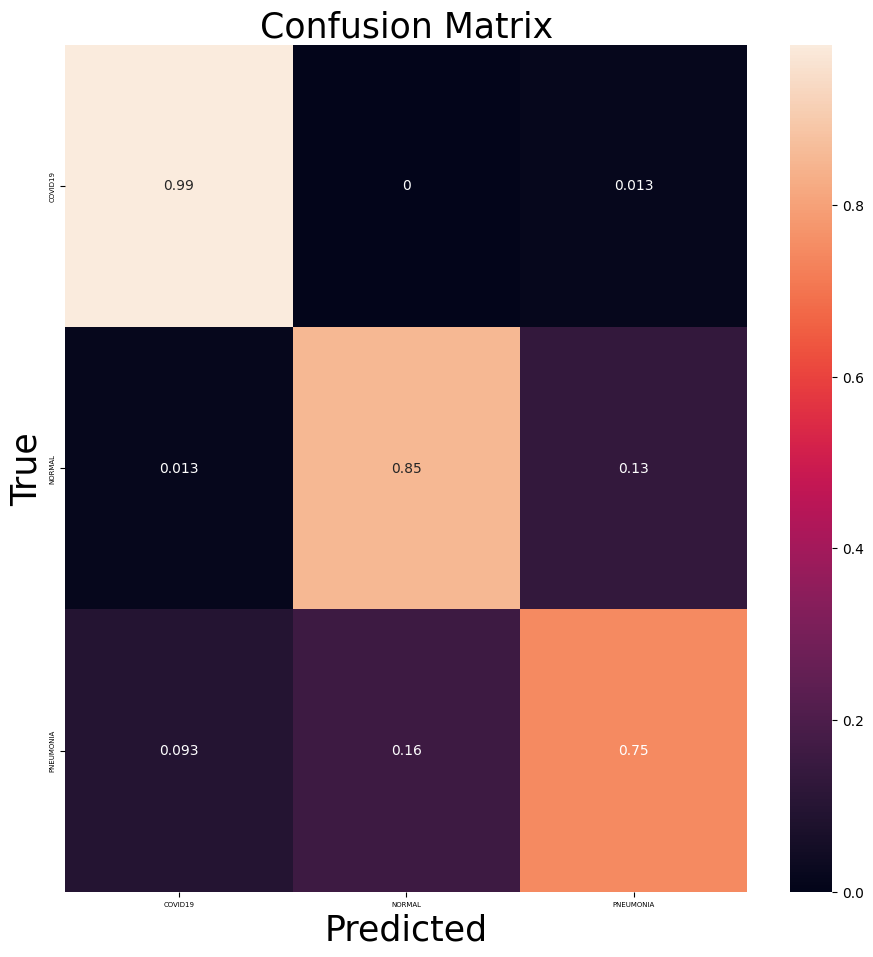

In [30]:
net.load_state_dict(torch.load(checkpoint_path, weights_only=True))
net = net.to(device)

correct, total = utils.test_evaluation(net = net, test_loader = test_loader_norm_radimagenet, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader_norm_radimagenet, net = net, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

**Questions**:

1. Comment on your choice of transfer learning approach (either finetuning last layers / all layers in the model) for RadImageNet? Why could the best approach here be different from ImageNet?

Fine-tuning All Layers: This approach, using RadImageNet pretraining, achieved 91% test accuracy and excelled in COVID-19 detection (97.3% precision and recall). Fine-tuning all layers lets the model adapt domain-specific features to the target task, crucial for nuanced medical imaging.

Freezing the Backbone: This method, where only the classifier was updated, performed with 86% test accuracy. Freezing limits adaptability, leaving the model unable to refine features for the specific dataset.

Why RadImageNet Shines: Unlike ImageNet, RadImageNet is tailored for radiology, providing a better feature foundation. Fine-tuning all layers fully exploits this advantage, while freezing wastes its potential.

### Overall Results:

Update the table with your results for all experiments from the exercise:

| Model    | Training                         | Test Accuracy |
|:-------: |:--------------------------------:|:-------------:|
| ResNet18 | from scratch                     |    83 %           |
| ResNet34 | from scratch                     |    78 %          |
| ResNet50 | from scratch                     |   68 %            |
| ResNet50 | from scratch (with augmentation) |   33 % ???            |
| ResNet50 | from ImageNet (all layers)       |   90 %            |
| ResNet50 | from ImageNet (last layers)      |    93 %           |
| ResNet50 | from RadImageNet                 |    91(86) %           |

**Question**:
Observations from the Results Table

1. Trend Analysis:
- Performance without pretraining: ResNet18 and ResNet34, trained from scratch, outperform ResNet50 under the same conditions. This suggests that deeper networks like ResNet50 require more data and training time to reach comparable performance.
- Effect of augmentation: Surprisingly, ResNet50 trained with augmentation performs worse (40% accuracy) than when trained from scratch without it. This may indicate improper augmentation parameters or data imbalances.
- Pretrained models: The models pretrained on ImageNet and RadImageNet significantly outperform those trained from scratch, highlighting the benefits of transfer learning.
- Fine-tuning layers: Fine-tuning all layers with ImageNet initialization (91%) gives slightly worse results than tuning only the last layers (93%).

2. Best Model:
- The best model is ResNet50 pretrained on ImageNet with last layers fine-tuned (93%).
- This aligns with expectations, as transfer learning on large, diverse datasets like ImageNet usually yields strong generalization performance for downstream tasks. However, RadImageNet’s performance (91%) is also competitive, likely because it specializes in medical imaging data, which may better align with the target domain.

**Important: Please read the end of the exercise sheet and upload the predictions from your best model, also if you choose not to try out to further improve it.**

## Further improve your model (*Optional*)

You can now try to further improve the model by using different architectures or trying some of the advanced training and inference techniques discussed in the lecture. This part of the exercise is optional, and you can try to apply as many approaches for improving your method as you would like. If you don't want to work on the optional part at all please go to the end of the exercise to submit the predictions from your best model.

Here are the aproaches you can try to improve the model:
1. Update the training hyperparameter:
    - You can choose a better initial learning rate, or choose different options for the learning rate scheduler or early stopping.
    - The most important parameter is probably the learning rate; if you want to improve it then train only for a short time and compare different values. (Remember lecture 2 and the first exercise). 
2. Try other architectures provided in `torchvision.models`, which implements further CNN architectures (and their respective ImageNet pretrained weights). For example `DenseNet` or `EfficientNet` could yield better results than ResNets.
    - `torchvision.models` also offers vision transformer architectures (https://arxiv.org/abs/2010.11929). We will cover those later in the lecture, but if you want you can try them here as well. See the snippet at the end of this section for details. 
3. Try advanced data augmentation strategies, which change the data manifold severly and can boost performance. For example MixUp or CutMix. `torchivsion` already implements them, see [data augmentation with torchvision](https://pytorch.org/vision/stable/transforms.html) for details.
4. Try test-time data augmentation. We have covered this idea in the lecture. To use it you don't need to change the training at all, but just update the model prediction during testing. Fot this you can either update the functionality in `ex3_utils.py` or implement a wrapper function or class around the model that implements the test-time data augmentation logic.
5. Try model ensembling: combine the predictions of different models on the test set or use an implicit averaging approach like polyak averaging. For this approaches you may need to update the training and/or prediction functions from `ex3_utils.py`.

Here's a snippet that shows how to use vision transformers from torchvision:

```python
# replacing the respective layers of the "transformer-based networks" to match our number of classes
net = torchvision.models.vit_b_16(pretrained=True)
net.heads.head = nn.Linear(768, num_classes)
net.to(device)
```

**Hint**: if you want to systematically improve your model you should proceed as follows:
- Decide on the base architecture and how to initialize it.
    - Either choose the best model you according to the exercise so far or try if advanced architectures from `torchvision` bring an improvement and continue with one of them.
- Optimize the training hyperparameters (learning rate, scheduling, early stopping).
- Investigate advanced techniques:
  - Training with more or advanced data augmentation.
  - Test-time data augmentation
  - Model ensembling

You can divide some of these tasks up among your group and train the best model by combining the best settings you have found for the individual steps.

## Train your best model

In [70]:
torch.cuda.empty_cache()

In [71]:
vgg16 = torchvision.models.vgg16(weights='IMAGENET1K_V1')

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace=True),
    #nn.Dropout(p=0.5, inplace=False),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace=True),
    #nn.Dropout(p=0.5, inplace=False),
    nn.Linear(2048, 3, bias = True)          
)
vgg16 = vgg16.to(device)

In [72]:
model_name = 'vgg16'
model = vgg16

lr = 0.0001
n_epochs = 30

checkpoint_name = f'covid-19-{model_name}.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
    
torch.cuda.empty_cache()
print("Starting training from scratch with network: ", model_name)

weights = torch.tensor([1, 5, 20], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight = weights)

optimizer = optim.Adagrad(params = model.parameters(), lr = lr, lr_decay=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 5, gamma = 0.1) 

early_stopping = utils.EarlyStopping(checkpoint_path, 5)
    
accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader = train_loader_normImageNet, 
                                                                     val_loader = val_loader_normImageNet, 
                                                                     net = model, 
                                                                     num_epochs = n_epochs, 
                                                                     criterion = criterion, 
                                                                     optimizer = optimizer, 
                                                                     #scheduler = scheduler, 
                                                                     early_stopping = early_stopping, 
                                                                     device = device
                                                                    )

The model checkpoint will be saved here:  /kaggle/working/covid-19-vgg16.pt
Starting training from scratch with network:  vgg16
450/450: [============================>...] - ETA 1.6ss
Epoch: 1
Training Loss: 0.761 , Training Accuracy:0.360 => Validation Loss: 0.620, Validation Accuracy: 0.533 
450/450: [============================>...] - ETA 1.5ss
Epoch: 2
Training Loss: 0.329 , Training Accuracy:0.556 => Validation Loss: 0.405, Validation Accuracy: 0.573 
450/450: [============================>...] - ETA 1.5ss
Epoch: 3
Training Loss: 0.177 , Training Accuracy:0.756 => Validation Loss: 0.485, Validation Accuracy: 0.920 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 1.5ss
Epoch: 4
Training Loss: 0.208 , Training Accuracy:0.887 => Validation Loss: 0.167, Validation Accuracy: 0.893 
450/450: [============================>...] - ETA 1.5ss
Epoch: 5
Training Loss: 0.067 , Training Accuracy:0.960 => Validation Loss: 0.227, Validation Accuracy: 0.860 
Ear

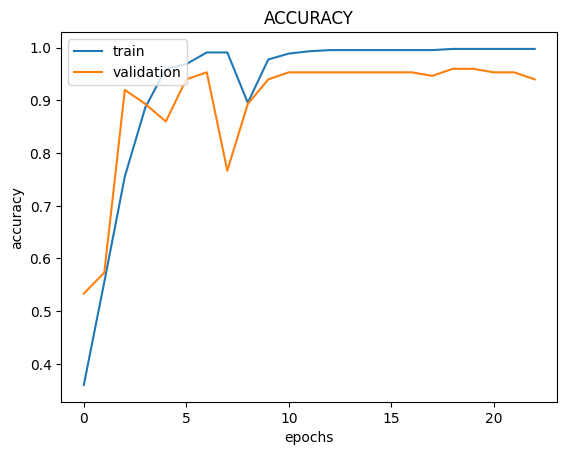

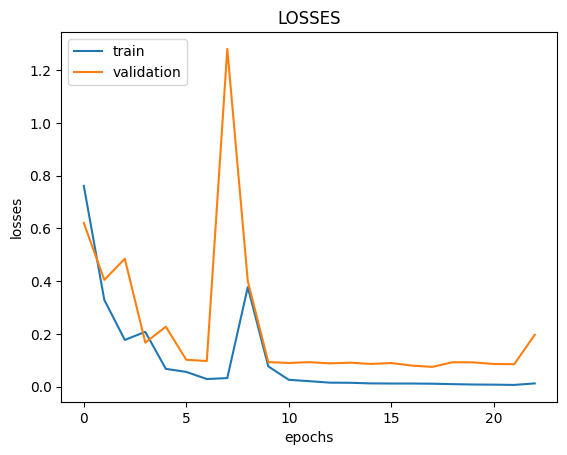

In [73]:
utils.get_metric_plots(train_metric = accuracy, val_metric = val_accuracy, metric_name = 'accuracy')
utils.get_metric_plots(train_metric = losses, val_metric = val_losses, metric_name = 'losses')

/kaggle/working/covid-19-vgg16.pt
Accuracy of /kaggle/working/covid-19-vgg16.pt on the Test Images: 95 %
COVID19 - recall :  1.0  precision :  0.9866667  accuracy :  0.9955556
NORMAL - recall :  0.9230769  precision :  0.96  accuracy :  0.96
PNEUMONIA - recall :  0.94520545  precision :  0.92  accuracy :  0.95555556
0.9555555555555556


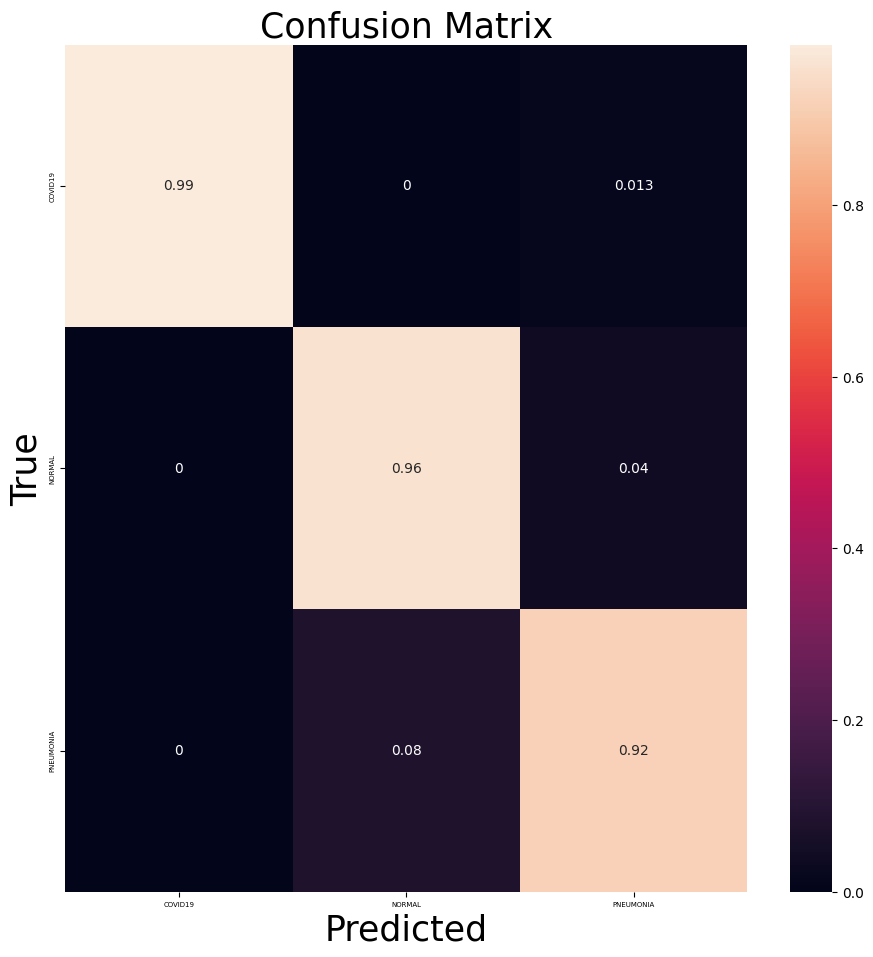

In [74]:
print(checkpoint_path)
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model = model.to(device)

correct, total = utils.test_evaluation(net = model, test_loader = test_loader, device = device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes = classes, test_loader = test_loader, net = model, device = device)
utils.check_precision_recall_accuracy(cm = cm, all_classes = classes)
utils.visualize_confusion_matrix(cm, classes, correct = correct, total = total)

## Submission:

- The `unknown` set corresponds to a hold-out test set (with unlabeled images). Such unseen test data is common in machine learning challenges to ensure an objective comparison of different methods and to test how well these solutions would generalize to real data.
- Submit the predictons for the `unknown` set using your best model together with your exercise solution.
    - Upload the solutions to `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Challenge Results`-> `Tutorial <X>`.
    - Your submission should be called `results_surname1_surname2_surname3.csv`. The expected file format is described below and we provide a function that generates these results for you already.
- **Please submit the results from your best model (or the model you expect to perform best). If you don't work on the optional part of the exercise then submit the best result from the models you have trained so far.**
    - The group with the best submission will get a small prize ;-) 

### Expected Submission Format

Before submitting your results, please make sure that they are in the below mentioned format:
- `results_<surname1>_<surname2>_<surname3>.csv`
    - patient_\<ID-1>.jpg | \<CLASS-1>
    - patient_\<ID-2>.jpg | \<CLASS-2> <br>
    . <br>
    . <br>
    . <br>
    - patient_\<ID_n>.jpg | \<CLASS-[1-3]>
 
We have prepared a function that generates these predictions for you (see below).

In [75]:
torch.cuda.empty_cache()

In [76]:
vgg_checkpoint_path = '/kaggle/working/covid-19-vgg16.pt'

print(vgg_checkpoint_path)
model.load_state_dict(torch.load(vgg_checkpoint_path, weights_only=True))
model = model.to(device)
net = model

/kaggle/working/covid-19-vgg16.pt


In [77]:
# TODO: YOUR SOLUTION HERE
filename = "results.csv"

# Function generating predictions (in a csv file) for the respective images in the hold-out test set (`unknown` folder)
# Note: if you want to use test-time-augmentation or model ensembling you may need to update this function.
# If you don't want to update it you can also create a new class that implements a wrapper around the model(s)
# that implements the augmentation or ensembling logic.
utils.predict_unknown(net, height, width, train_dataset_mean, train_dataset_std, unknown_dir, device, filename)

# Download link is automatically generated for the final results generated
FileLink(filename)

100%|██████████| 5607/5607 [01:22<00:00, 68.33it/s]


/kaggle/working/results.csv